# PyTorch Quick Intro

In [1]:
from __future__ import print_function, division
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
from skimage import io, transform

from torch.utils.data import Dataset, DataLoader
from torchvision import utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Torch tensors

In [9]:
x = torch.empty(5,3) # The tensor is declared, but is not initialised until it is called.
print(x)

tensor([[9.2755e-39, 9.1837e-39, 9.3674e-39],
        [1.0745e-38, 1.0653e-38, 9.5510e-39],
        [1.0561e-38, 1.0194e-38, 1.1112e-38],
        [1.0561e-38, 9.9184e-39, 1.0653e-38],
        [4.1327e-39, 1.0194e-38, 1.0469e-38]])


In [8]:
torch.rand(5,3)

tensor([[0.4421, 0.9674, 0.0405],
        [0.1658, 0.2378, 0.3807],
        [0.4474, 0.2475, 0.7873],
        [0.9130, 0.1290, 0.7992],
        [0.2462, 0.4021, 0.4922]])

In [10]:
x = torch.zeros(5,3,dtype=torch.long)

In [11]:
x = torch.tensor([5.5,3])

In [17]:
x = torch.zeros(5, 3, dtype=torch.float64)

In [18]:
x.dtype

torch.float64

In [21]:
# create a tensor based on an existing tensor. These methods will reuse 
# properties of the input tensor, e.g. dtype, unless new values are 
# provided by user.
x = x.new_zeros(5,3)

In [22]:
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [24]:
x = torch.randn_like(x, dtype=torch.float)
y = x

### Tensor operations

In [25]:
# We can specify an existing tensor to output the result
# of a tensor operation to.
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

tensor([[-0.8168, -0.7649,  0.3509],
        [-2.4888, -1.7089,  2.4779],
        [ 2.5253, -1.6260, -3.5909],
        [ 0.3883, -1.6747,  3.6882],
        [-3.3261,  1.1986, -1.7762]])


In [26]:
# adds x to y
y.add_(x)
print(y)

tensor([[-0.8168, -0.7649,  0.3509],
        [-2.4888, -1.7089,  2.4779],
        [ 2.5253, -1.6260, -3.5909],
        [ 0.3883, -1.6747,  3.6882],
        [-3.3261,  1.1986, -1.7762]])


In [29]:
# use torch.view to resize tensors.
x.view(-1,5)

tensor([[-0.8168, -0.7649,  0.3509, -2.4888, -1.7089],
        [ 2.4779,  2.5253, -1.6260, -3.5909,  0.3883],
        [-1.6747,  3.6882, -3.3261,  1.1986, -1.7762]])

In [33]:
# Convert a single element of a tensor to a python object.
x = torch.randn(1)
print(x)
print(x.item())

tensor([1.2497])
1.2496694326400757


In [34]:
# Convert tensor to NumPy array.
a = torch.ones(5)
print(a)

b = a.numpy()
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


In [37]:
# The resulting NumPy array is a reference and NOT a copy. 
# ie modifications to the original tensor will modify
# the NumPy array as well.
a.add_(1)
print(a)
print(b)

tensor([4., 4., 4., 4., 4.])
[4. 4. 4. 4. 4.]


In [38]:
# NumPy arrays can be converted to tensors.
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


### CUDA tensors
Tensors can be moved onto any device using the .to method.

In [44]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

tensor([2.2497], device='cuda:0')
tensor([2.2497], dtype=torch.float64)


### Autograd
```torch.Tensor``` is the central class of the package. If you set its attribute ```.requires_grad``` as ```True```, it starts to track all operations on it. When you finish your computation you can call ```.backward()``` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into ```.grad``` attribute.

To stop a tensor from tracking history, you can call ```.detach()``` to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with ```torch.no_grad():```. This can be particularly helpful when evaluating a model because the model may have trainable parameters with ```requires_grad=True```, but for which we don’t need the gradients.

There’s one more class which is very important for autograd implementation - a ```Function```.

```Tensor``` and ```Function``` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a ```.grad_fn``` attribute that references a ```Function``` that has created the ```Tensor``` (except for ```Tensor``` objects created by the user - their ```grad_fn``` is ```None```).

If you want to compute the derivatives, you can call ```.backward()``` on a ```Tensor```. If ```Tensor``` is a scalar (i.e. it holds a one element data), you don’t need to specify any arguments to ```backward()```, however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

In [45]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [46]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [47]:
print(y.grad_fn)

In [53]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [50]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


### Gradients
Let’s backprop now. Because ```out``` contains a single scalar, ```out.backward()``` is equivalent to ```out.backward(torch.tensor(1.))```.

In [54]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [57]:
# Vector-Jacobian product.
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 100:
    y = y * 2 + 1

print(y)

tensor([12.3792, 53.6494, 93.4781], grad_fn=<AddBackward0>)


In [58]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([3.2000e+00, 3.2000e+01, 3.2000e-03])


In [59]:
# Stop autograd from tracking gradient history.
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


### Defining models

In [63]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [64]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [65]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0724, -0.0006, -0.0893, -0.1224,  0.0519, -0.0938, -0.0550,  0.0765,
          0.0252, -0.0084]], grad_fn=<AddmmBackward>)


In [66]:
# Zero the gradient buffers of all parameters and backprops with random gradients.
net.zero_grad()
out.backward(torch.randn(1, 10))

##### Recap:
 * ```torch.Tensor``` - A multi-dimensional array with support for autograd operations like ```backward()```. Also holds the gradient w.r.t. the tensor.
 * ```nn.Module``` - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.
 * ```nn.Parameter``` - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a ```Module```.
 * ```autograd.Function``` - Implements forward and backward definitions of an autograd operation. Every ```Tensor``` operation creates at least a single ```Function``` node that connects to functions that created a ```Tensor``` and encodes its history.

### Loss functions

In [68]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9681, grad_fn=<MseLossBackward>)


In [69]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [70]:
net.zero_grad()     # zeroes the gradient buffers of all parameters. Do this after every iteration.

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0057,  0.0013, -0.0108,  0.0061,  0.0035, -0.0016])


### Weight updates

In [73]:
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

### Train a classifier

In [78]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|█████████▉| 170369024/170498071 [00:48<00:00, 3693756.46it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


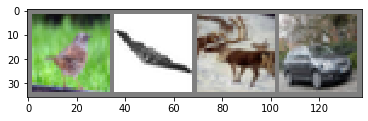

 bird plane  deer   car


In [81]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [82]:
# Define network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [83]:
# Define loss function and optimiser.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [84]:
# Train the network.
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.218
[1,  4000] loss: 1.874
[1,  6000] loss: 1.703
[1,  8000] loss: 1.606
[1, 10000] loss: 1.538
[1, 12000] loss: 1.471
[2,  2000] loss: 1.397
[2,  4000] loss: 1.338
[2,  6000] loss: 1.317
[2,  8000] loss: 1.313
[2, 10000] loss: 1.280
[2, 12000] loss: 1.268
Finished Training


In [85]:
# Save the model.
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

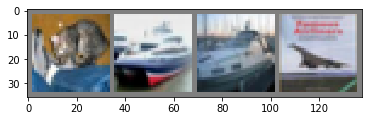

GroundTruth:    cat  ship  ship plane


In [86]:
# Test the trained CNN
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [87]:
# Loading model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [88]:
outputs = net(images) # These are the energies.

In [89]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane  ship plane


In [90]:
# Test on all test data.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [91]:
# Get class-wise accuracy.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73 %
Accuracy of   car : 69 %
Accuracy of  bird : 19 %
Accuracy of   cat : 43 %
Accuracy of  deer : 60 %
Accuracy of   dog : 38 %
Accuracy of  frog : 34 %
Accuracy of horse : 69 %
Accuracy of  ship : 54 %
Accuracy of truck : 72 %


### Training on GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
net.to(device) # Move the neural net to the GPU.
inputs, labels = data[0].to(device), data[1].to(device)

NameError: name 'net' is not defined

### Loading custom data
From https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
plt.ion()   # interactive mode

In [5]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


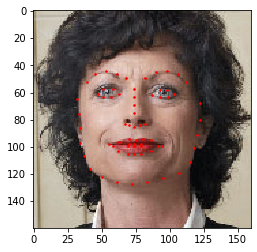

In [6]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

In [7]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


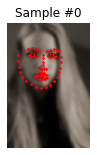

1 (500, 333, 3) (68, 2)


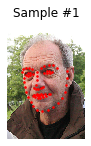

2 (250, 258, 3) (68, 2)


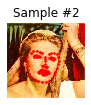

3 (434, 290, 3) (68, 2)


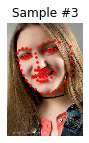

In [8]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

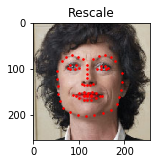

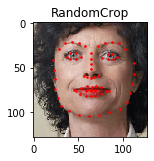

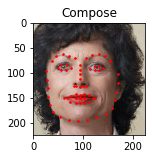

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = torchvision.transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [11]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=torchvision.transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [14]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

"""for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break"""

"for i_batch, sample_batched in enumerate(dataloader):\n    print(i_batch, sample_batched['image'].size(),\n          sample_batched['landmarks'].size())\n\n    # observe 4th batch and stop.\n    if i_batch == 3:\n        plt.figure()\n        show_landmarks_batch(sample_batched)\n        plt.axis('off')\n        plt.ioff()\n        plt.show()\n        break"

In [19]:
data_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomSizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = torchvision.datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'hymenoptera_data/train'